In [1]:
# the fastest way is to have the files on drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Getting the data, EDA

Necessary imports for first steps

In [21]:
from matplotlib.pyplot import imshow
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
import pandas as pd
import numpy as np
import time
# to make this notebook's output stable across runs
np.random.seed(0)
from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler # we can also do /X.max() 


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

BASE_PATH = '/content/drive/My Drive'
FER_PATH = '/content/drive/My Drive/fer2013.csv'
FER_CLEAN_PATH = '/content/drive/My Drive/fer_clean.csv'
PATH_TRAIN_NODUP = os.path.join(BASE_PATH, 'fer_train_nodup.csv')
PATH_DEV_NODUP = os.path.join(BASE_PATH, 'fer_dev_nodup.csv')
PATH_TEST_NODUP = os.path.join(BASE_PATH, 'fer_test_nodup.csv')
PATH_AUG = os.path.join(BASE_PATH, 'augmented_train.csv')
PATH_BALANCED = os.path.join(BASE_PATH, 'balancednk.csv')
label_map = {0: 'Anger',
           1: 'Disgust',
           2: 'Fear',
           3: 'Happy',
           4: 'Sad',
           5: 'Surprise',
           6: 'Neutral'}

First look at the data

In [23]:
fer = pd.read_csv(FER_PATH)
# download here: https://www.kaggle.com/ahmedmoorsy/facial-expression
fer.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
# columns, dtypes, etc. we see that pixels column has type object, 
# meaning that it's all strings
fer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [6]:
# the data contains 3 subsets depending on the usage
# we will use PublicTest as dev set and PrivateTest to evaluate NN models sometimes.
# in this notebook the last set is not used
fer.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

### Transforming the data to numerical format

Now the problem is that we have 1 column with all pixel values in it. Our goal is to split this column into 2034 columns, each for 1 pixel

In [9]:
def string_to_ints(row, i):
    """
    Args:
        row: string with 2034 integer numbers separated by space
    Returns:
        i-th number in row
    """
    return int(row.split()[i])  

# this code takes some time to run, since we have ~35K of strings
def bad_fer2good_fer(path_to_bad_fer=FER_PATH, path_to_save_good_fer = FER_CLEAN_PATH):
    '''
    Transforms pixel column into 2034 columns with pixel values
    Args: 
        path_tobad_fer: path to initial data
        path_to_save_good_fer: path to save the resulting dataframe, defaults to 'fer_clean.csv'
    Returns:
        transformed DF with 2034 new columns with int values
    '''
    bad_fer = pd.read_csv(path_to_bad_fer)
    good_fer = bad_fer.copy()
    for i in range(len(bad_fer.pixels[0].split())):
        good_fer[f'p_{i}'] = good_fer.apply(lambda row: string_to_ints(row['pixels'], i), axis=1)
    good_fer.to_csv(path_to_save_good_fer)
    return good_fer

df = bad_fer2good_fer()
df.head()

### Label Check

In [28]:
def check_fix_labels(path_2_good_fer = FER_CLEAN_PATH, quantity=15):
        """
        Takes some quantity of randomly picked images from data, plot s them and
        asks user if she/he agrees or not with the assigned label. If not, then
        the label suggested by user is put instead and then saved. The func allows
        to see the issues with the data and fix some of them.
        Args:
            path_2_good_fer: path to csv file with integer arrays for all pics
        Returns:
            fixed DF
        """
        
        df = pd.read_csv(path_2_good_fer) 
        
        if 'Unnamed: 0' in df.columns:
            df = df.drop('Unnamed: 0', axis=1)

        pics_to_check = df.sample(quantity)
        print(f'Label map: {label_map}')
        for row_index in pics_to_check.index.tolist():
            plt.figure()
            plt.imshow(np.array(df.iloc[row_index,3:].astype('int')).reshape(48, 48))
            plt.title(f'Assigned label: {label_map[df.emotion[row_index]]}')
            plt.show()
            is_label_ok = str(input('Do you agree, y/n? '))

            if is_label_ok in {'y', 'Y', 'yes', 'Yes'}:
                print('fine :)')
            if is_label_ok in {'n', 'N', 'No', 'no'}:
                fixed_label = int(input("Let's fix the label then. What label do \
you think is appropriate here? Please, input integer [0,.. 6] \
according to the label map. "))

                while fixed_label not in range(7):
                    fixed_label = int(input("What label do \
you think is appropriate here? Please, input integer [0,.. 6] \
according to the label map. "))
                    
                df.emotion[row_index] = fixed_label
        # saving changes
        df.to_csv(path_2_good_fer) 
        return df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Columns: 2307 entries, emotion to p_2303
dtypes: int64(2305), object(2)
memory usage: 631.6+ MB


None

Label map: {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


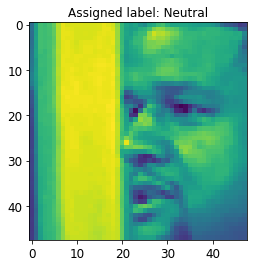

Do you agree, y/n? y
fine :)


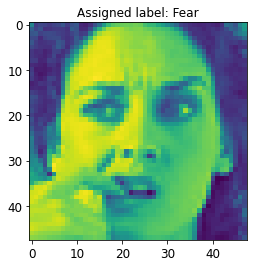

Do you agree, y/n? n
Let's fix the label then. What label do you think is appropriate here? Please, input integer [0,.. 6] according to the label map. 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


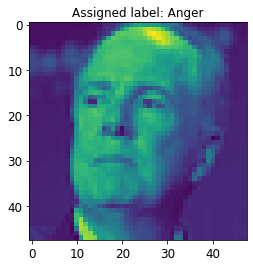

Do you agree, y/n? n
Let's fix the label then. What label do you think is appropriate here? Please, input integer [0,.. 6] according to the label map. 6


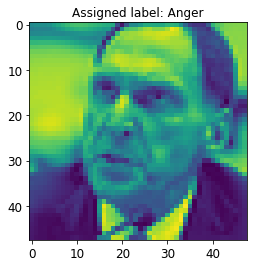

Do you agree, y/n? y
fine :)


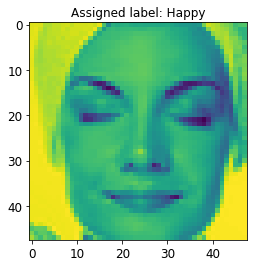

Do you agree, y/n? y
fine :)


,emotion,pixels,Usage,p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,p_11,p_12,p_13,p_14,p_15,p_16,p_17,p_18,p_19,p_20,p_21,p_22,p_23,p_24,p_25,p_26,p_27,p_28,p_29,p_30,p_31,p_32,p_33,p_34,p_35,p_36,...,p_2264,p_2265,p_2266,p_2267,p_2268,p_2269,p_2270,p_2271,p_2272,p_2273,p_2274,p_2275,p_2276,p_2277,p_2278,p_2279,p_2280,p_2281,p_2282,p_2283,p_2284,p_2285,p_2286,p_2287,p_2288,p_2289,p_2290,p_2291,p_2292,p_2293,p_2294,p_2295,p_2296,p_2297,p_2298,p_2299,p_2300,p_2301,p_2302,p_2303
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,70,80,82,72,58,58,60,63,54,58,60,48,89,115,121,119,115,110,98,91,84,84,90,99,110,126,143,153,158,171,169,172,169,165,129,110,113,...,20,31,40,46,65,88,108,110,125,149,157,153,162,164,158,159,154,140,78,21,11,61,144,168,173,157,138,150,148,132,159,182,183,136,106,116,95,106,109,82
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,151,150,147,155,148,133,111,140,170,174,182,154,153,164,173,178,185,185,189,187,186,193,194,185,183,186,180,173,166,161,147,133,172,151,114,161,161,...,150,129,143,135,115,102,111,124,112,109,132,146,135,149,148,143,163,156,159,150,139,128,116,125,133,109,130,147,130,121,105,108,95,108,102,67,171,193,183,184
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,231,212,156,164,174,138,161,173,182,200,106,38,39,74,138,161,164,179,190,201,210,216,220,224,222,218,216,213,217,220,220,218,217,212,174,160,162,...,225,220,215,207,199,167,108,151,122,88,71,84,120,127,105,76,71,78,90,106,123,146,155,148,130,141,119,69,54,89,104,138,152,122,114,101,97,88,110,152
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,24,32,36,30,32,23,19,20,30,41,21,22,32,34,21,19,43,52,13,26,40,59,65,12,20,63,99,98,98,111,75,62,41,73,118,140,192,...,124,150,161,167,169,167,162,164,169,181,172,168,169,170,174,179,180,182,196,208,226,230,140,113,114,125,135,141,172,214,174,126,132,132,133,136,139,142,143,142
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,4,0,0,0,0,0,0,0,0,0,0,0,3,15,23,28,48,50,58,84,115,127,137,142,151,156,155,149,153,152,157,160,162,159,145,121,83,...,18,27,19,13,11,22,37,48,55,67,88,95,112,118,123,141,157,174,181,185,184,179,176,171,155,128,105,10,0,0,12,34,31,31,31,27,31,30,29,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest,50,36,17,22,23,29,33,39,34,37,37,37,39,43,48,50,53,60,67,69,72,73,82,86,87,94,94,89,84,78,78,80,73,68,63,59,56,...,31,29,29,26,24,25,28,33,36,37,42,43,45,45,50,46,52,53,47,41,35,38,50,59,66,68,74,62,110,217,216,215,216,217,221,222,220,223,221,216
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest,178,174,172,173,181,188,191,194,196,199,200,201,204,206,202,195,185,182,183,184,188,191,194,192,187,182,182,184,187,189,190,187,184,180,172,167,164,...,133,135,157,171,188,186,177,177,168,157,155,144,126,117,111,128,157,163,163,160,158,165,169,175,178,176,173,170,166,155,147,141,136,118,66,7,0,0,0,0
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest,17,17,16,23,28,22,19,17,25,26,20,24,31,19,27,92,164,195,220,150,123,190,168,86,82,134,183,198,91,106,89,30,78,114,110,100,76,...,141,158,139,116,104,105,87,44,32,41,54,62,66,72,88,123,131,122,106,119,137,125,112,112,123,150,157,164,176,199,190,179,193,193,194,170,148,154,133,113
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest,30,28,28,29,31,30,42,68,79,81,77,67,67,71,63,61,78,108,142,147,123,113,111,107,113,125,136,145,137,118,101,85,64,59,71,83,85,...,134,137,129,123,122,106,97,92,91,90,87,84,89,91,79,64,70,74,73,69,65,56,47,36,30,35,33,29,28,29,30,27,27,26,28,35,35,35,30,28


In [59]:
check_fix_labels(quantity=5)

### Train - Dev - Test split & Cleaning Duplicates

In [3]:
def split_and_remove_dups(path_to_fer_clean=FER_CLEAN_PATH, path_save_train=PATH_TRAIN_NODUP, path_save_dev=PATH_DEV_NODUP, path_save_test=PATH_TEST_NODUP):
        """
        Removes duplicating images from the whole data (so, we don't consider labels,
        since sometimes they are different for the same pics) and splits the data 
        according to Usage and saves all 3 subsets in csv files
        Args:
            path_to_fer_clean: path to numeric data with all 3 datasets
            path_save_train: path to save train set w/o duplicates
            path_save_dev: path to save dev set w/o duplicates
            path_save_test: path to save test set w/o duplicates
        Returns:
            X train, dev and test; y train dev and test
        """
        df = pd.read_csv(path_to_fer_clean)
        df = df.drop(columns=['pixels'])

        # time to check duplicates
        print(f'We got {np.sum((df.iloc[:, 3:].duplicated()))} duplicated images\
 in the data, let\'s drop that.')
        
        # and drop them
        df = df[~df.iloc[:, 3:].duplicated()].reset_index()

        # splitting into trand-dev-test subsets
        df_train = df[df.Usage=='Training'].drop(columns=['Usage'])
        X_train, y_train = df_train.drop(columns=['emotion']), df_train.emotion.values

        df_dev = df[df.Usage=='PublicTest'].drop(columns=['Usage'])
        X_dev, y_dev = df_dev.drop(columns=['emotion']), df_dev.emotion.values

        df_test = df[df.Usage=='PrivateTest'].drop(columns=['Usage'])
        X_test, y_test = df_test.drop(columns=['emotion']), df_test.emotion.values

        # sometimes some useless coulmns appear and make problems for .iloc, etc
        for data in [X_train, X_test, X_dev, df_train, df_dev, df_test]:
            if 'index' in data.columns:
                data = data.drop('index', axis=1, inplace=True)
            # if 'Unnamed: 0' in data.columns:
            #     data = data.drop('Unnamed: 0', axis=1, inplace=True)

        # and saving all them
        df_train.to_csv(path_save_train, index=False)
        df_test.to_csv(path_save_test, index=False)
        df_dev.to_csv(path_save_dev, index=False)
        return X_train, y_train, X_dev, y_dev, X_test, y_test


In [4]:
X_train, y_train, X_dev, y_dev, X_test, y_test = split_and_remove_dups()
X_train.head()

We got 1853 duplicated images in the data, let's drop that.


,Unnamed: 0,p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,p_11,p_12,p_13,p_14,p_15,p_16,p_17,p_18,p_19,p_20,p_21,p_22,p_23,p_24,p_25,p_26,p_27,p_28,p_29,p_30,p_31,p_32,p_33,p_34,p_35,p_36,p_37,p_38,...,p_2264,p_2265,p_2266,p_2267,p_2268,p_2269,p_2270,p_2271,p_2272,p_2273,p_2274,p_2275,p_2276,p_2277,p_2278,p_2279,p_2280,p_2281,p_2282,p_2283,p_2284,p_2285,p_2286,p_2287,p_2288,p_2289,p_2290,p_2291,p_2292,p_2293,p_2294,p_2295,p_2296,p_2297,p_2298,p_2299,p_2300,p_2301,p_2302,p_2303
0,0,70,80,82,72,58,58,60,63,54,58,60,48,89,115,121,119,115,110,98,91,84,84,90,99,110,126,143,153,158,171,169,172,169,165,129,110,113,107,95,...,20,31,40,46,65,88,108,110,125,149,157,153,162,164,158,159,154,140,78,21,11,61,144,168,173,157,138,150,148,132,159,182,183,136,106,116,95,106,109,82
1,1,151,150,147,155,148,133,111,140,170,174,182,154,153,164,173,178,185,185,189,187,186,193,194,185,183,186,180,173,166,161,147,133,172,151,114,161,161,146,131,...,150,129,143,135,115,102,111,124,112,109,132,146,135,149,148,143,163,156,159,150,139,128,116,125,133,109,130,147,130,121,105,108,95,108,102,67,171,193,183,184
2,2,231,212,156,164,174,138,161,173,182,200,106,38,39,74,138,161,164,179,190,201,210,216,220,224,222,218,216,213,217,220,220,218,217,212,174,160,162,160,139,...,225,220,215,207,199,167,108,151,122,88,71,84,120,127,105,76,71,78,90,106,123,146,155,148,130,141,119,69,54,89,104,138,152,122,114,101,97,88,110,152
3,3,24,32,36,30,32,23,19,20,30,41,21,22,32,34,21,19,43,52,13,26,40,59,65,12,20,63,99,98,98,111,75,62,41,73,118,140,192,186,187,...,124,150,161,167,169,167,162,164,169,181,172,168,169,170,174,179,180,182,196,208,226,230,140,113,114,125,135,141,172,214,174,126,132,132,133,136,139,142,143,142
4,4,4,0,0,0,0,0,0,0,0,0,0,0,3,15,23,28,48,50,58,84,115,127,137,142,151,156,155,149,153,152,157,160,162,159,145,121,83,58,48,...,18,27,19,13,11,22,37,48,55,67,88,95,112,118,123,141,157,174,181,185,184,179,176,171,155,128,105,10,0,0,12,34,31,31,31,27,31,30,29,30


In [10]:
X_train = X_train.drop(columns=['Unnamed: 0'])

Ok, now when we are done with defining our train, dev and test sets, let's see what we have :) 

### 2-dimensional plots

Let's just visualize on plane some relatively small chunk of our train set

Pipeline with PCA and t-SNE took 4.21s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


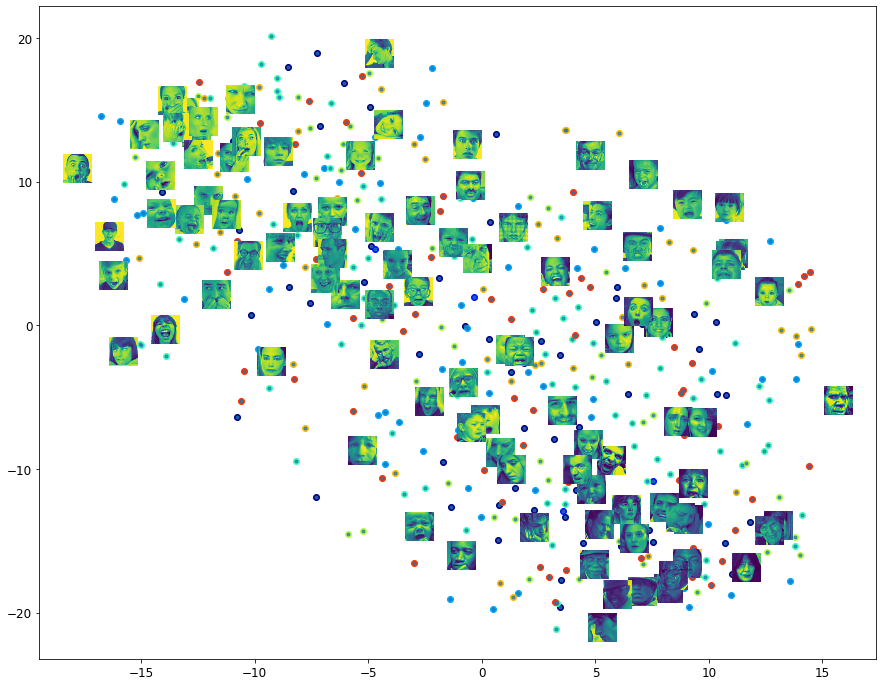

In [57]:
def plot_tsne_xtrain(X_train, chunk_size=500):
    """
    Reduces dimensionality of some part of rescaled X_train in Pipeline with 
    PCA and t-SNE and plots it on plane.
    Args:
        X_train: train set with only pixel values, no need for labels
        chunk_size: number of first rows to plot
    """
    if 'index' in X_train.columns:
        X_train = X_train.drop('index', axis=1)

    mm = MinMaxScaler()
    X_train_scaled_small = mm.fit_transform(X_train.iloc[:chunk_size, :])
    y_train_small = y_train[:chunk_size]

    pca_tsne = Pipeline([
        ("pca", PCA(n_components=0.95, random_state=0)),
        ("tsne", TSNE(n_components=2, random_state=0)),
    ])
    t0 = time.time()
    X_pca_tsne_reduced_train = pca_tsne.fit_transform(X_train_scaled_small)
    t1 = time.time()
    print(f"Pipeline with PCA and t-SNE took {round(t1-t0, 2)}s")


    fig = plt.figure(figsize=(16,16))
    cmap = mpl.cm.get_cmap("jet")
    emotion_labels = np.unique(y_train_small)
    for em in emotion_labels:
        plt.scatter(X_pca_tsne_reduced_train[y_train_small == em, 0], X_pca_tsne_reduced_train[y_train_small == em, 1], c=[cmap(em / 7)])

    fig.set_size_inches(15, 12)
    ax = fig.add_subplot(111)
    # Show 2D components plot
    manifold_2D = pd.DataFrame(X_pca_tsne_reduced_train, columns=['Component 1', 'Component 2'])
    ax.scatter(manifold_2D['Component 1'], manifold_2D['Component 2'], marker='.',alpha=0.7)

    for _ in range(100):
        random_index = np.random.randint(X_train_scaled_small.shape[0])
        array_to_img = np.array(X_train_scaled_small[random_index, :]).reshape(48, 48)
        ab = AnnotationBbox(OffsetImage(array_to_img, zoom=0.6), (manifold_2D['Component 1'][random_index], 
                                                        manifold_2D['Component 2'][random_index]),
                                                        frameon=False)
        ax.add_artist(ab)




plot_tsne_xtrain(X_train)

Pipeline with PCA and Isomap took 0.73s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


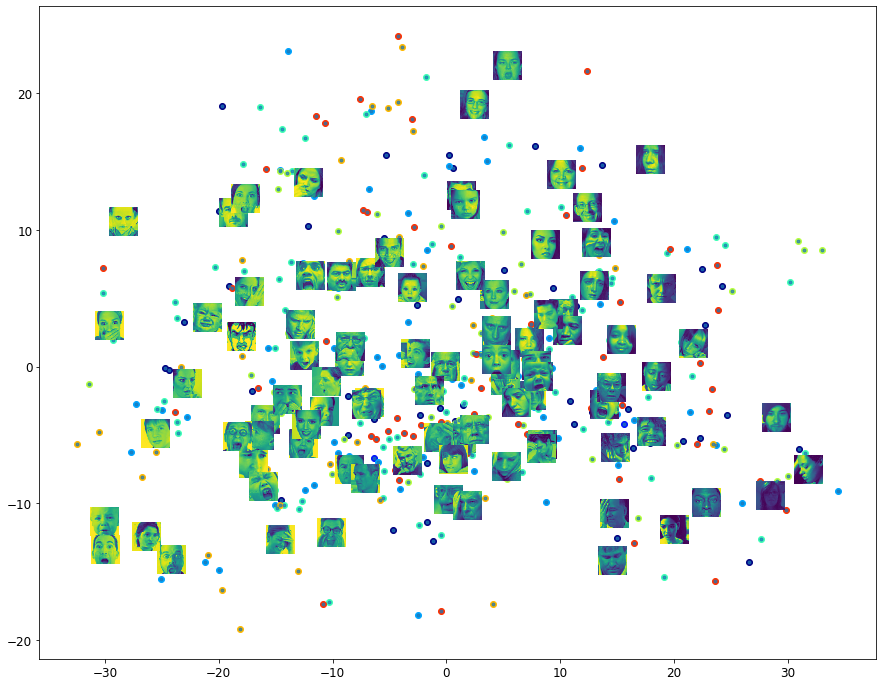

In [58]:
def plot_isomap_xtrain(X_train, chunk_size=500):
    """
    Reduces dimensionality of some part of rescaled X_train in Pipeline with 
    PCA and IsoMap and plots it on plane.
    Args:
        X_train: train set with only pixel values, no need for labels
        chunk_size: number of first rows to plot
    """
    if 'index' in X_train.columns:
        X_train = X_train.drop('index', axis=1)

    mm = MinMaxScaler()
    X_train_scaled_small = mm.fit_transform(X_train.iloc[:chunk_size, :])
    y_train_small = y_train[:chunk_size]

    pca_isomap = Pipeline([
        ("pca", PCA(n_components=0.95, random_state=0)),
        ("isomap", Isomap(n_components=2)),
    ])
    t0 = time.time()
    X_pca_im_reduced_train = pca_isomap.fit_transform(X_train_scaled_small)

    t1 = time.time()
    print(f"Pipeline with PCA and Isomap took {round(t1-t0, 2)}s")


    # plot

    fig = plt.figure(figsize=(16,16))
    cmap = mpl.cm.get_cmap("jet")
    emotion_labels = np.unique(y_train_small)
    for em in emotion_labels:
        plt.scatter(X_pca_im_reduced_train[y_train_small == em, 0], X_pca_im_reduced_train[y_train_small == em, 1], c=[cmap(em / 7)])

    fig.set_size_inches(15, 12)
    ax = fig.add_subplot(111)
    # Show 2D components plot
    manifold_2D = pd.DataFrame(X_pca_im_reduced_train, columns=['Component 1', 'Component 2'])
    ax.scatter(manifold_2D['Component 1'], manifold_2D['Component 2'], marker='.',alpha=0.7)

    for _ in range(100):
        random_index = np.random.randint(X_train_scaled_small.shape[0])
        array_to_img = np.array(X_train_scaled_small[random_index, :]).reshape(48, 48)
        ab = AnnotationBbox(OffsetImage(array_to_img, zoom=0.6), (manifold_2D['Component 1'][random_index], 
                                                        manifold_2D['Component 2'][random_index]),
                                                        frameon=False)
        ax.add_artist(ab)

plot_isomap_xtrain(X_train)

We can see that both plots have images with different emotions as close points on the plane, this means that distance between points doesn't reflect how similar are the facial expressions . We can see other issues with both methods: t-SNE spreads the images on the plane according to the lightness of picture, and IsoMap makes a huge overlap of pictures with probably different labels.

### Augmentate train set

In [5]:
import cv2
import imutils
from skimage.transform import AffineTransform, warp

def horiz_flip_row(row):
    """
    Horizontally flips the image (this means that it flips the image with respect 
    to the vertical line)
    Args:
        row with 2034 integers of pixel values of original image
    Returns:
        row with 2034 pixel values of transformed image
    """
    img_array = np.array(row).reshape(48, -1)
    flipped_img = np.fliplr(img_array)
    flipped_row = pd.DataFrame(list(flipped_img.reshape(1, 2304)), columns=X_train.columns)
    return flipped_row


def rotate_row(row): 
    """
    Rotates the image on some random angle between -20 and 20
    Args:
        row with 2034 integers of pixel values of original image
    Returns:
        row with 2034 pixel values of transformed image
    """
    img_row = np.array(row).reshape(48, 48)
    angle = np.random.randint(-20, 20)
    cv2.imwrite('fer_row_to_rotate.jpg', img_row)
    rotated_img = imutils.rotate(cv2.imread('fer_row_to_rotate.jpg'), angle)
    rotated_row = pd.DataFrame(list(rotated_img[:,:,0].reshape(1, 2304)), columns=X_train.columns)
    return rotated_row


def move_vertically_row(row):
    """
    Moves image up or down a bit
    Args:
        row with 2034 integers of pixel values of original image
    Returns:
        row with 2034 pixel values of transformed image
    """
    shift = np.random.randint(-6, 6)
    af_trans = AffineTransform(translation=(0, shift)) 
    img_array = np.array(row).reshape(48, -1)
    shifted_img = warp(img_array, af_trans, mode='wrap')
    shifted_row = pd.DataFrame(list(shifted_img.reshape(1, 2304)), columns=X_train.columns)
    return shifted_row
    
    
def move_horizontally_row(row):
    """
    Moves image left or righ a bit
    Args:
        row with 2034 integers of pixel values of original image
    Returns:
        row with 2034 pixel values of transformed image
    """
    shift = np.random.randint(-6, 6)
    af_trans = AffineTransform(translation=(shift, 0)) 
    img_array = np.array(row).reshape(48, -1)
    shifted_img = warp(img_array, af_trans, mode='wrap')
    shifted_row = pd.DataFrame(list(shifted_img.reshape(1, 2304)), columns=X_train.columns)
    return shifted_row

def noise_row(row, noise_type='gaussian'):
    """
    Induces some random noise on the image. For now, it's only gaussian
    Other options will be added later
    Args:
        row with 2034 integers of pixel values of original image
    Returns:
        row with 2034 pixel values of transformed image
    """
    img_array = np.array(row).reshape(48, -1)
    if noise_type=='gaussian':
        row, col = img_array.shape
        mean, var = np.random.randint(60, 80), np.random.randint(9, 25) 
        gauss = np.random.normal(mean, np.sqrt(var), (row, col)).reshape(row, col)
        noised_img = img_array+gauss
        noised_row = pd.DataFrame(list(noised_img.reshape(1, 2304)), columns=X_train.columns)
        return noised_row

def blur_row(row):
    """
    Puts gaussian blur on the image
    Args:
        row with 2034 integers of pixel values of original image
    Returns:
        row with 2034 pixel values of transformed image
    """
    img_array = np.array(row).reshape(48, -1)
    cv2.imwrite('fer_row_to_blur.jpg', img_array)
    blurred_img = cv2.GaussianBlur(cv2.imread('fer_row_to_blur.jpg'), (3, 3), 0)[:,:,0]
    blurred_row = pd.DataFrame(list(blurred_img.reshape(1, 2304)), columns=X_train.columns)
    return blurred_row

def zoom_in_row(row): 
    """
    Zooms in te image
    Args:
        row with 2034 integers of pixel values of original image
    Returns:
        row with 2034 pixel values of transformed image
    """
    img_array = np.array(row).reshape(48, -1)
    cv2.imwrite('fer_row_to_zoom.jpg', img_array)
    zoomed_img = cv2.resize(cv2.imread('fer_row_to_zoom.jpg'),None,fx=1.5, fy=1.5)[18:66,18:66,0]
    zoomed_row = pd.DataFrame(list(zoomed_img.reshape(1, 2304)), columns=X_train.columns)
    return zoomed_row

trans_options = ['horiz_flip_row', 'rotate_row', 'move_vertically_row', 'move_horizontally_row', 
              'blur_row', 'noise_row', 'zoom_in_row']

def augmentate(row_index, X_train, y_train, horiz_flip=True, rotate_r=True, move_vert=False, move_hor=False, blur_r=False, noise_r=True, zoom_in=False):
    """
    Horizontally flips the image (this means that it flips the image with respect 
    to the vertical line)
    Args:
        row_index: index of row to take image and it's label from
        X_train, y_train: train data, pixel values of images and labels
        horiz_flip: boolean, defaults to True
        rotate_r: boolean, defaults to True
        move_vert: boolean, defaults to False
        move_hor:  boolean, defaults to False
        blur_r: boolean, defaults to False
        noise_r: boolean, defaults to True
        zoom_in: boolean, defaults to False
    Returns:
        dataframe with pixel values for generated images
        labels for new images (same label as the label of original pic)
    """
    start_df = X_train.head(0)
    initial_row, its_label = X_train.iloc[row_index,:], y_train[row_index]
    finish_label = [its_label]*np.sum([horiz_flip, rotate_r, move_vert, move_hor, blur_r, noise_r, zoom_in])
    if horiz_flip:
        start_df = start_df.append(horiz_flip_row(initial_row))
    if rotate_r:
        start_df = start_df.append(rotate_row(initial_row))
    if move_vert:
        start_df = start_df.append(move_vertically_row(initial_row))
    if move_hor:
        start_df = start_df.append(move_horizontally_row(initial_row))
    if blur_r:
        start_df = start_df.append(blur_row(initial_row))
    if noise_r:
        start_df = start_df.append(noise_row(initial_row))
    if zoom_in:
        start_df = start_df.append(zoom_in_row(initial_row))
    return start_df, finish_label



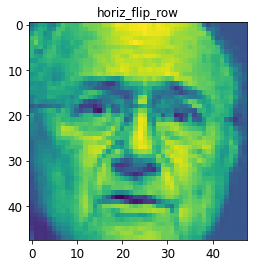

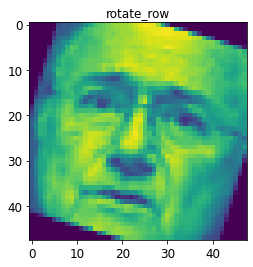

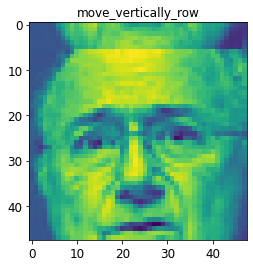

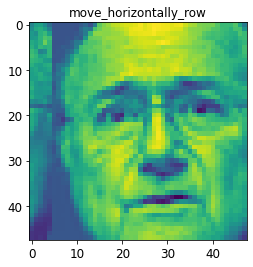

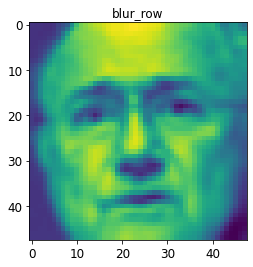

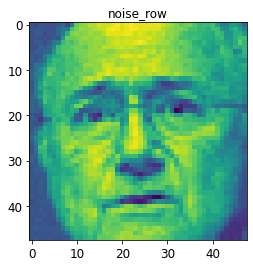

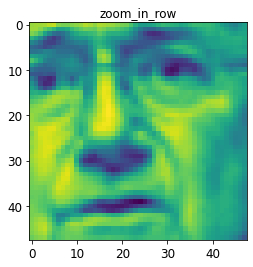

In [64]:
# let's try to generate new images for the image in the 5th row
new_x_chunk, new_y_labels = augmentate(5, X_train, y_train, zoom_in=True, blur_r=True, move_vert=True, move_hor=True)
for i in range(len(new_x_chunk)):
    plt.figure()
    plt.imshow(np.array(new_x_chunk.iloc[i,:]).reshape(48, 48))
    plt.title(trans_options[i])

In [8]:
def augment_train(X_train, y_train, max_quantity_to_add=3500, path_to_save_aug=PATH_AUG):
    """
    Takes train set, images and labels, and generates some number of new pics of each label
    Args:
        X_train: df with pixel values
        y_train: labels
        max_quantity_to_add: maximal quantity of images of each label to be generated
        path_to_save_aug: path to save df with generated and train images together
    """

    t0 = time.time()
    start_x, start_y = X_train.head(0), list([5])
    # dict with counters, we'll make < max_quantity_to_add pics for each label
    counters_dict = {label: 0 for label in np.unique(y_train)}

    # now, let's take 1 random image out of all generated for each row until we reach max_quantity_to_add 
    # in the previous version, the whole amount of generated pics for each row was taken
    # so, we will have more variety, but the code might be slower

    for i in X_train.index.tolist(): 
        if counters_dict[y_train[i]] <= max_quantity_to_add:
            new_x_chunk, new_y_labels = augmentate(i, X_train, y_train)
            random_guy = new_x_chunk.sample(1)
            his_label = new_y_labels[0]
            start_x = start_x.append(random_guy)
            start_y.append(his_label)
            counters_dict[y_train[i]] += 1
            # start_x = start_x.append(new_x_chunk) # previous
            # start_y = start_y + new_y_labels # previous
            # counters_list[y_train[i]] += len(new_y_labels) # previous    
    t1 = time.time()
    print(f'Generating new {len(start_x)} images took {t1-t0}s')
    start_y = start_y[1:]
    augmented_train_x = X_train.append(start_x)
    augmented_train_y = list(y_train) + start_y

    augmented_train = augmented_train_x.copy().astype('int32')
    augmented_train['emotion'] = pd.Series(augmented_train_y)
    for i in range(len(augmented_train)):
        augmented_train.iloc[i,-1] = augmented_train_y[i]

    # flip columns here to make it easier to work later
    cols = list(augmented_train.columns)
    cols = [cols[-1]] + cols[:-1]
    augmented_train = augmented_train[cols]

    augmented_train.to_csv(path_to_save_aug)
    return augmented_train

In [115]:
# let's first try some small quantity
try_aug = augment_train(X_train, y_train, max_quantity_to_add=10, path_to_save_aug='try_aug.csv')
try_aug.tail()

Generating new 77 images took 34.421584129333496s


,emotion,p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,p_11,p_12,p_13,p_14,p_15,p_16,p_17,p_18,p_19,p_20,p_21,p_22,p_23,p_24,p_25,p_26,p_27,p_28,p_29,p_30,p_31,p_32,p_33,p_34,p_35,p_36,p_37,p_38,...,p_2264,p_2265,p_2266,p_2267,p_2268,p_2269,p_2270,p_2271,p_2272,p_2273,p_2274,p_2275,p_2276,p_2277,p_2278,p_2279,p_2280,p_2281,p_2282,p_2283,p_2284,p_2285,p_2286,p_2287,p_2288,p_2289,p_2290,p_2291,p_2292,p_2293,p_2294,p_2295,p_2296,p_2297,p_2298,p_2299,p_2300,p_2301,p_2302,p_2303
0,1,60,62,51,68,64,60,66,62,65,62,68,117,252,263,267,286,278,278,281,292,305,298,294,299,301,299,303,300,306,305,302,299,300,297,299,293,292,289,286,...,63,62,65,60,67,61,101,207,201,202,210,206,221,218,209,222,230,233,243,250,248,241,241,251,252,248,246,239,247,246,241,240,241,240,245,238,243,251,248,242
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,13,35,60,67,60,58,42,34,22,19,16,13,14,14,17,23,30,40,46,37,35,...,12,11,15,22,18,28,53,57,66,95,98,83,76,77,77,76,77,80,93,102,102,78,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,330,304,219,143,118,118,134,142,143,163,191,187,185,166,153,145,140,124,115,114,110,125,118,117,127,116,122,118,127,136,137,148,157,168,156,138,130,104,106,...,284,193,167,136,119,105,208,262,222,244,270,256,226,237,249,212,174,173,163,158,177,177,192,185,188,157,155,115,103,119,131,134,135,147,157,192,297,326,328,328
0,1,0,0,0,0,0,0,0,0,0,0,10,18,27,38,56,71,84,91,107,125,135,143,153,168,169,161,173,194,185,168,167,166,154,125,123,152,161,158,159,...,69,70,56,32,26,26,19,19,33,47,76,92,93,96,98,100,101,109,115,118,113,105,89,71,57,47,36,42,45,34,20,0,0,0,0,0,0,0,0,0
0,1,87,89,99,102,102,99,106,104,112,115,115,113,108,120,82,9,0,0,14,48,52,55,66,67,66,73,72,65,62,65,52,51,54,49,54,57,48,27,52,...,111,87,91,78,89,112,133,150,160,153,150,142,143,124,102,103,98,75,76,80,76,64,56,56,58,68,59,58,48,33,23,20,14,10,7,10,2,1,3,0


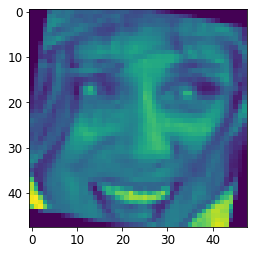

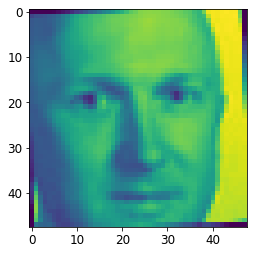

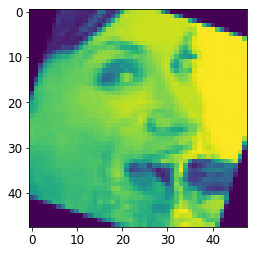

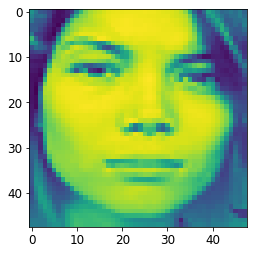

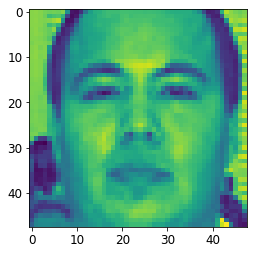

In [117]:
# plotting some synthetic images. they are appended to the tail, 
# so they have row indices -77, -76, ... -1
for rowpic in try_aug.iloc[-45:-40, 1:].values:
    plt.figure()
    plt.imshow(np.array(rowpic).reshape(48, 48))

In [11]:
# here we augment train data adding 3500 new images of each label
aug = augment_train(X_train, y_train)

Generating new 20562 images took 10472.169058561325s


In [12]:
aug.tail(3)

,emotion,p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,p_11,p_12,p_13,p_14,p_15,p_16,p_17,p_18,p_19,p_20,p_21,p_22,p_23,p_24,p_25,p_26,p_27,p_28,p_29,p_30,p_31,p_32,p_33,p_34,p_35,p_36,p_37,p_38,...,p_2264,p_2265,p_2266,p_2267,p_2268,p_2269,p_2270,p_2271,p_2272,p_2273,p_2274,p_2275,p_2276,p_2277,p_2278,p_2279,p_2280,p_2281,p_2282,p_2283,p_2284,p_2285,p_2286,p_2287,p_2288,p_2289,p_2290,p_2291,p_2292,p_2293,p_2294,p_2295,p_2296,p_2297,p_2298,p_2299,p_2300,p_2301,p_2302,p_2303
0,5,255,255,255,255,252,253,179,57,44,56,40,47,46,58,57,48,48,43,54,56,42,57,61,60,55,51,38,43,45,46,60,60,52,47,73,147,228,255,252,...,5,3,2,6,5,0,2,3,1,47,86,84,91,91,76,59,63,79,106,139,155,156,143,147,164,134,12,3,6,7,7,5,6,6,8,6,7,8,9,15
0,5,226,228,231,231,233,236,238,238,240,241,242,243,244,245,246,246,247,247,247,248,248,248,249,249,249,249,249,248,249,249,248,247,247,246,245,244,244,243,242,...,57,34,151,165,177,127,146,167,176,193,158,127,167,171,175,197,188,131,169,187,195,198,199,209,194,194,193,72,50,59,62,45,81,239,255,254,255,255,255,255
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,54,97,131,163,184,181,177,173,168,163,162,163,162,161,157,156,158,156,150,141,137,...,92,87,83,80,64,79,138,225,233,240,251,224,192,192,199,205,208,206,203,160,110,71,40,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
aug.shape # 28K of original images + 20K of new ones

(48035, 2305)

In [16]:
 # if augmentation was done before, then 
aug_loaded = pd.read_csv(PATH_AUG).drop(columns=['Unnamed: 0'])
aug_loaded.tail(3)

,emotion,p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,p_11,p_12,p_13,p_14,p_15,p_16,p_17,p_18,p_19,p_20,p_21,p_22,p_23,p_24,p_25,p_26,p_27,p_28,p_29,p_30,p_31,p_32,p_33,p_34,p_35,p_36,p_37,p_38,...,p_2264,p_2265,p_2266,p_2267,p_2268,p_2269,p_2270,p_2271,p_2272,p_2273,p_2274,p_2275,p_2276,p_2277,p_2278,p_2279,p_2280,p_2281,p_2282,p_2283,p_2284,p_2285,p_2286,p_2287,p_2288,p_2289,p_2290,p_2291,p_2292,p_2293,p_2294,p_2295,p_2296,p_2297,p_2298,p_2299,p_2300,p_2301,p_2302,p_2303
48032,5,255,255,255,255,252,253,179,57,44,56,40,47,46,58,57,48,48,43,54,56,42,57,61,60,55,51,38,43,45,46,60,60,52,47,73,147,228,255,252,...,5,3,2,6,5,0,2,3,1,47,86,84,91,91,76,59,63,79,106,139,155,156,143,147,164,134,12,3,6,7,7,5,6,6,8,6,7,8,9,15
48033,5,226,228,231,231,233,236,238,238,240,241,242,243,244,245,246,246,247,247,247,248,248,248,249,249,249,249,249,248,249,249,248,247,247,246,245,244,244,243,242,...,57,34,151,165,177,127,146,167,176,193,158,127,167,171,175,197,188,131,169,187,195,198,199,209,194,194,193,72,50,59,62,45,81,239,255,254,255,255,255,255
48034,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,54,97,131,163,184,181,177,173,168,163,162,163,162,161,157,156,158,156,150,141,137,...,92,87,83,80,64,79,138,225,233,240,251,224,192,192,199,205,208,206,203,160,110,71,40,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Ideal (almost) balance

In [20]:
  def rebalance(train_path=PATH_TRAIN_NODUP, aug_path=PATH_AUG, desired_q=5000, balanced_path=PATH_BALANCED):
    """
     Balances the data in a nice way :) 
     For each label we aim to reach desired_q amount of images. If the train data
     contains enough images of some label, then this desired_q number of pictures
     with such label are randomly selected from the data. If not, then all original 
     images are taken from the train set and the additional amount is randomly 
     picked from synthetic images

    Args: 
        train_path: path to train set with origianl images and labels
        aug_path: path to df with augmented train set
        desired_q: desired quantity of images in each label
        balanced_path: path to save new df with balanced classes
    Returns:
        df with balanced classes
    """
    fer_train = pd.read_csv(train_path).drop(columns=['Unnamed: 0'])
    aug = pd.read_csv(aug_path).drop(columns=['Unnamed: 0'])

    balanced5k = pd.DataFrame(columns = aug.columns)
    

    for label in np.unique(fer_train.emotion):
        how_many_pics = fer_train.emotion.value_counts()[label]
        if how_many_pics >= desired_q: #enough pics
            balanced5k = balanced5k.append(fer_train[fer_train.emotion==label].sample(desired_q))
        else: # not enough, have to add (desired_q - how_many_pics) synthetic images
            balanced5k = balanced5k.append(fer_train[fer_train.emotion==label])
            balanced5k = balanced5k.append(aug.iloc[len(fer_train):,:][aug.emotion==label].sample(min(aug.iloc[len(fer_train):,:].emotion.value_counts()[label], desired_q-how_many_pics)))
    print('Now the classes in target are almost balanced :)')
    print(balanced5k.emotion.value_counts())
    balanced5k.to_csv(balanced_path)
    return balanced5k

In [24]:
# 6000 is a bit extreme value. label 1 is a problematic since it was poorely
# represented in the initial data
# so, values for desired_q like 3000-4000 are also okay
balanced6k = rebalance(desired_q=6000, balanced_path='balanced6k.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Now the classes in target are almost balanced :)
6    6000
4    6000
3    6000
2    6000
0    6000
5    5350
1     764
Name: emotion, dtype: int64


Nice, the preprocessing & augmentation is done! :) Yay!